In [22]:
##Engineer, Generative AI

In [23]:
#Development of an Adaptable Deep Learning Model for Artistic Style Transfer
"""

The aim of this assignment is to create a deep learning model capable of 
adapting an existing work to resemble the aesthetic of any art. The model should
be able to analyze the artistic style of the selected art and apply similar
stylistic features to a new, original artwork, creating a piece that seems as 
though it could have been created by the artist themselves.
"""

'\n\nThe aim of this assignment is to create a deep learning model capable of \nadapting an existing work to resemble the aesthetic of any art. The model should\nbe able to analyze the artistic style of the selected art and apply similar\nstylistic features to a new, original artwork, creating a piece that seems as \nthough it could have been created by the artist themselves.\n'

In [24]:
import tensorflow as t
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)

%matplotlib inline

print(t.__version__)

2.8.0


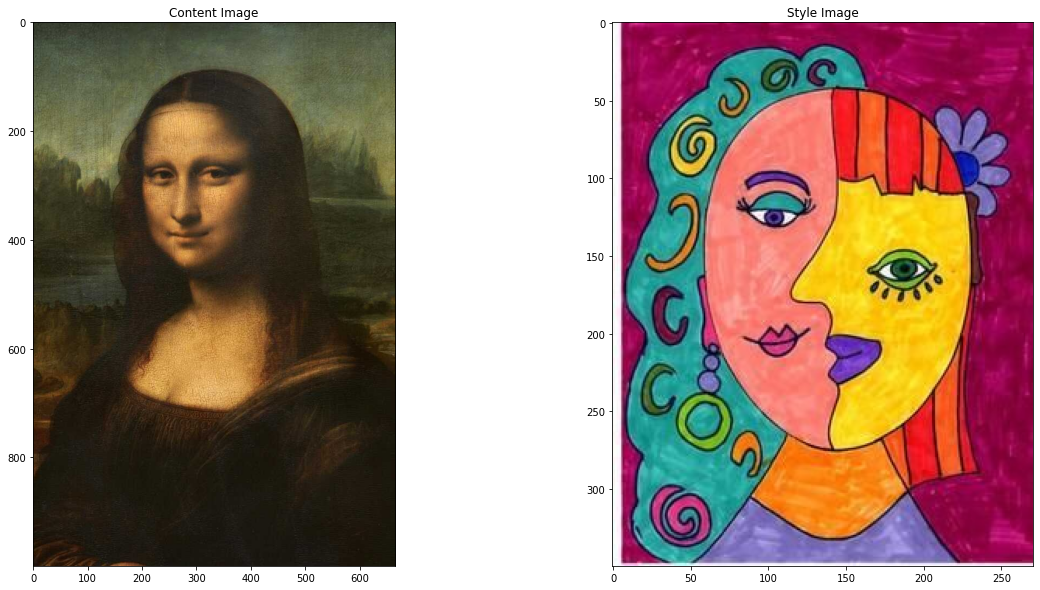

In [25]:
# Load the content and style images
content = plt.imread('contentMona.jpg')
style = plt.imread('picassoStyle.jpg')

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()


In [26]:
def load_image(image):
      image = plt.imread(image)
      img = t.image.convert_image_dtype(image, t.float32)
      img = t.image.resize(img, [400, 400])
      # Shape -> (batch_size, h, w, d)
      img = img[t.newaxis, :]
      return img


In [27]:
# Use load_image of content and style images
content = load_image('contentMona.jpg')
style = load_image('picassoStyle.jpg')

# Verify the shapes
content.shape, style.shape


(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

In [28]:
vgg = t.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False



In [29]:
# Print the layer names for convenience
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [30]:
'conv1_1'
'conv2_1'
'conv3_1'
'conv4_1'
'conv5_1'


'conv5_1'

In [31]:
# Content layer
content_layers = ['block4_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [32]:
def mini_model(layer_names, model):

  outputs = [model.get_layer(name).output for name in layer_names]

  model = Model([vgg.input], outputs)
  return model


In [33]:
# Gram matrix
def gram_matrix(tensor):
  temp = tensor
  temp = t.squeeze(temp)
  fun = t.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = t.matmul(temp, temp, transpose_b=True)
  gram = t.expand_dims(result, axis=0)
  return gram


In [34]:
 class Custom_Style_Model(t.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg =  mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # Scale back the pixel values
    inputs = inputs*255.0
    # Preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # Pass through the mini network
    outputs = self.vgg(preprocessed_input)
    # Segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [35]:
# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']


#optimization was done using the L-BFGS algorithm, but we can use Adam also.

In [36]:
opt = t.optimizers.Adam(learning_rate=0.02)


In [37]:
 # Custom weights for style and content updates
style_weight=100
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

In [38]:
# The loss function to optimize
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = t.add_n([style_weights[name]*t.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_style_layers

    content_loss = t.add_n([t.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [39]:
@t.function()
def train_step(image):
  with t.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(t.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [40]:
target_image = t.Variable(content)


In [41]:
epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()

In [ ]:
#Limitations and Potential improvements of the model.

In [ ]:
"""The provided code implements neural style transfer using a VGG19-based model
 and the Adam optimizer. While the code demonstrates the basic process of style 
 transfer, there are some limitations and potential improvements to consider.

**Limitations:**
1. **Single Style Transfer:** The current implementation is designed for a single 
style transfer. Adapting it for multiple styles or incorporating user-specific
 styles would enhance its flexibility.
2. **Computational Intensity:** Style transfer, especially with neural networks, 
can be computationally intensive. Fine-tuning or optimizing the model architecture
 may be necessary to achieve a balance between performance and computational cost.
3. **Hyperparameter Tuning:** The weights for style and content loss, as well as the 
weights for different style layers, are set manually. A more systematic approach, 
such as hyperparameter tuning, could improve the model's performance.

**Potential Improvements:**
1. **User Interface:** Creating a user interface or integrating the style transfer
 functionality into a user-friendly application would make it more accessible to 
 users without coding knowledge.
2. **Dynamic Style Adaptation:** Developing a method for dynamic style adaptation
 during the training process could allow the model to adapt its learned features 
 to new styles
more effectively.
3. **Transfer Learning:** Considering pre-trained models for style representatio
 or exploring transfer learning techniques could enhance the model's ability to
  generalize across different artistic styles.
4. **Evaluation Metrics:** Defining and incorporating quantitative evaluation
 metrics, such as perceptual similarity or user studies, would provide a more 
 objective measure of the model's performance.

Overall, while the provided code serves as a good starting point, addressing these 
limitations and incorporating potential improvements could enhance the versatility
 and performance of the neural style transfer model.
"""

"The provided code implements neural style transfer using a VGG19-based model\n and the Adam optimizer. While the code demonstrates the basic process of style \n transfer, there are some limitations and potential improvements to consider.\n\n**Limitations:**\n1. **Single Style Transfer:** The current implementation is designed for a single \nstyle transfer. Adapting it for multiple styles or incorporating user-specific\n styles would enhance its flexibility.\n2. **Computational Intensity:** Style transfer, especially with neural networks, \ncan be computationally intensive. Fine-tuning or optimizing the model architecture\n may be necessary to achieve a balance between performance and computational cost.\n3. **Hyperparameter Tuning:** The weights for style and content loss, as well as the \nweights for different style layers, are set manually. A more systematic approach, \nsuch as hyperparameter tuning, could improve the model's performance.\n\n**Potential Improvements:**\n1. **User In